# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('/content/stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [0]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [0]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w]+')
""" TOKENIZE_RE = re.compile(r'[а-яА-ЯёЁ]+|-?\d*[.,]?\d+|\S', re.I) """

import spacy 
import nltk
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm

snowBallStemmer = SnowballStemmer("english")


def tokenize_text_simple_regex1(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [nlp(token)[0].lemma_ for token in all_tokens if len(token) >= min_token_size]

# nlp(token)[0].lemma_

def tokenize_corpus1(texts, tokenizer=tokenize_text_simple_regex1, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in tqdm(texts)]


In [5]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
nlp = spacy.load("en_core_web_sm")

In [22]:
train_tokenized = tokenize_corpus1(train_source['data'])
test_tokenized = tokenize_corpus1(test_source['data'])

print(' '.join(train_tokenized[0]))


  2%|▏         | 211/11314 [04:41<9:10:04,  2.97s/it]

KeyboardInterrupt: ignored

In [8]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 17344
[('that', 0), ('-PRON-', 1), ('have', 2), ('this', 3), ('write', 4), ('with', 5), ('post', 6), ('article', 7), ('host', 8), ('nntp', 9)]


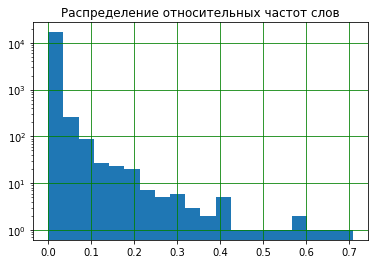

In [9]:
plt.figure(facecolor="white", num="red")
plt.grid(True, color='green')
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [27]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

KeyboardInterrupt: ignored

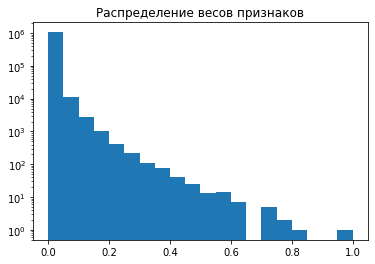

In [11]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [12]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


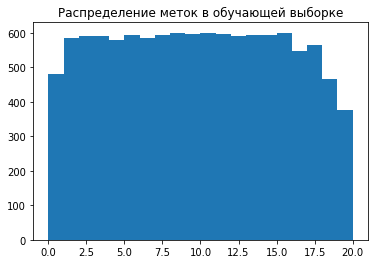

In [13]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

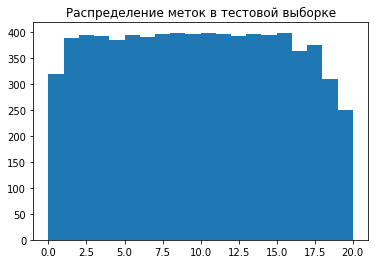

In [14]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [0]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [24]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

"""class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.d1 = torch.nn.Dropout()
        self.fc1 = torch.nn.Linear(UNIQUE_WORDS_N, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.d2 = torch.nn.Dropout()
        self.bn1 = torch.nn.BatchNorm1d(num_features=n_hidden_neurons)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, UNIQUE_LABELS_N) 
    
    def forward(self, x):
        x = self.d1(x)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.d2(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x
    
model = MNISTNet(100)"""

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0.01,
                                            optimizer_ctor=torch.optim.AdamW,
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                                                       patience=5,
                                                                                                                       factor=0.5,
                                                                                                                       verbose=True))

Эпоха 0
Эпоха: 354 итераций, 3.45 сек
Среднее значение функции потерь на обучении 2.274366094230932
Среднее значение функции потерь на валидации 2.308838165412515
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 3.40 сек
Среднее значение функции потерь на обучении 1.1973375181357067
Среднее значение функции потерь на валидации 2.024167004783275
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.35 сек
Среднее значение функции потерь на обучении 0.8436050319065482
Среднее значение функции потерь на валидации 1.9050632745532665
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.43 сек
Среднее значение функции потерь на обучении 0.6948559873521665
Среднее значение функции потерь на валидации 1.8439363281605607
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 3.36 сек
Среднее значение функции потерь на обучении 0.6120328532773897
Среднее значение функции потерь на валидации 1.7941548597004453
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.58 сек
Среднее значение функции потер

## Оценка качества

In [25]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                                        torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()

test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                                        torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))



  0%|          | 0/353.5625 [00:00<?, ?it/s]

  5%|▍         | 17/353.5625 [00:00<00:02, 166.99it/s]

 10%|▉         | 34/353.5625 [00:00<00:01, 167.21it/s]

 14%|█▍        | 51/353.5625 [00:00<00:01, 165.26it/s]

 20%|█▉        | 69/353.5625 [00:00<00:01, 168.60it/s]

 25%|██▍       | 87/353.5625 [00:00<00:01, 168.76it/s]

 29%|██▉       | 103/353.5625 [00:00<00:01, 165.90it/s]

 33%|███▎      | 118/353.5625 [00:00<00:01, 159.69it/s]

 38%|███▊      | 134/353.5625 [00:00<00:01, 157.16it/s]

 43%|████▎     | 151/353.5625 [00:00<00:01, 159.28it/s]

 48%|████▊     | 168/353.5625 [00:01<00:01, 161.83it/s]

 52%|█████▏    | 185/353.5625 [00:01<00:01, 163.06it/s]

 57%|█████▋    | 203/353.5625 [00:01<00:00, 165.65it/s]

 62%|██████▏   | 220/353.5625 [00:01<00:00, 165.53it/s]

 67%|██████▋   | 237/353.5625 [00:01<00:00, 165.45it/s]

 72%|███████▏  | 254/353.5625 [00:01<00:00, 165.75it/s]

 77%|███████▋  | 271/353.5625 [00:01<00:00, 161.74it/s]

 81%|████████▏ | 288/353.5625 [00:01<00:00, 1

Среднее значение функции потерь на обучении 0.2759672999382019
Доля верных ответов 0.9967297153968535





 14%|█▍        | 33/235.375 [00:00<00:01, 162.31it/s]

 21%|██        | 50/235.375 [00:00<00:01, 162.29it/s]

 28%|██▊       | 66/235.375 [00:00<00:01, 159.81it/s]

 35%|███▌      | 83/235.375 [00:00<00:00, 161.95it/s]

 42%|████▏     | 99/235.375 [00:00<00:00, 159.75it/s]

 50%|████▉     | 117/235.375 [00:00<00:00, 163.24it/s]

 57%|█████▋    | 134/235.375 [00:00<00:00, 165.08it/s]

 64%|██████▍   | 151/235.375 [00:00<00:00, 164.39it/s]

 71%|███████   | 167/235.375 [00:01<00:00, 161.16it/s]

 78%|███████▊  | 184/235.375 [00:01<00:00, 161.55it/s]

 85%|████████▌ | 201/235.375 [00:01<00:00, 161.64it/s]

 92%|█████████▏| 217/235.375 [00:01<00:00, 159.17it/s]

 99%|█████████▉| 233/235.375 [00:01<00:00, 158.12it/s]

236it [00:01, 160.29it/s]                             

Среднее значение функции потерь на валидации 1.5299698114395142
Доля верных ответов 0.7468135953266065


# Альтернативная реализация на scikit-learn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [19]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.495478891857855
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258233705
Доля верных ответов 0.8190387679235263
